In [2]:
from __future__ import division, print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

%cd HepG2

/users/avanti/interpret-benchmark/data/HepG2


In [14]:
import keras
from keras.models import model_from_json
from keras.models import Model

model_prefix = "record_1_model_v4VYz"
model_weights = "model_files/"+model_prefix+"_modelWeights.h5"
model_json = "model_files/"+model_prefix+"_modelJson.json"

keras_model = model_from_json(open(model_json).read())
keras_model.load_weights(model_weights)

preact_model = Model(inputs=keras_model.input,
                     outputs=keras_model.layers[-2].output)

In [9]:
import h5py
import numpy as np

imp_scores_fh = h5py.File("imp_scores_"+model_prefix+".h5", "r")
print(imp_scores_fh.keys())

[u'onehot', u'scores_deeplift_genomicsdefault_avgposref', u'scores_deeplift_genomicsdefault_dinucshuff', u'scores_deeplift_genomicsdefault_flatref', u'scores_deeplift_rescale_avgposref', u'scores_deeplift_rescale_dinucshuff', u'scores_deeplift_rescale_flatref', u'scores_grad_times_inp_avgposref', u'scores_grad_times_inp_flatref', u'scores_integrated_grad10_avgposref', u'scores_integrated_grad10_dinucshuff', u'scores_integrated_grad10_flatref', u'scores_integrated_grad20_avgposref', u'scores_integrated_grad20_dinucshuff', u'scores_integrated_grad20_flatref', u'scores_integrated_grad2_avgposref', u'scores_integrated_grad2_dinucshuff', u'scores_integrated_grad2_flatref', u'scores_integrated_grad5_avgposref', u'scores_integrated_grad5_dinucshuff', u'scores_integrated_grad5_flatref', u'scores_ism']


In [15]:
onehot_seq = np.array(imp_scores_fh['onehot'])
orig_preds = preact_model.predict(onehot_seq)

In [11]:
onehot_seq.shape

(1240, 1000, 4)

In [16]:
orig_preds

array([[ 73.66543 ],
       [ 64.7831  ],
       [ 59.83736 ],
       ...,
       [-30.599043],
       [-32.22333 ],
       [-34.481323]], dtype=float32)

In [17]:
scoring_methods = [
    'scores_deeplift_genomicsdefault_avgposref',
    'scores_deeplift_genomicsdefault_dinucshuff',
    'scores_deeplift_genomicsdefault_flatref',
    'scores_deeplift_rescale_avgposref',
    'scores_deeplift_rescale_dinucshuff',
    'scores_deeplift_rescale_flatref',
    'scores_grad_times_inp_avgposref',
    'scores_grad_times_inp_flatref',
    'scores_integrated_grad10_avgposref',
    'scores_integrated_grad10_dinucshuff', 
    'scores_integrated_grad10_flatref',
    'scores_integrated_grad20_avgposref',
    'scores_integrated_grad20_dinucshuff',
    'scores_integrated_grad20_flatref',
    'scores_integrated_grad2_avgposref',
    'scores_integrated_grad2_dinucshuff',
    'scores_integrated_grad2_flatref',
    'scores_integrated_grad5_avgposref',
    'scores_integrated_grad5_dinucshuff',
    'scores_integrated_grad5_flatref',
    'scores_ism'   
]

In [71]:
%matplotlib inline
from matplotlib import pyplot as plt
import sys

from deeplift.visualization import viz_sequence

percentile = 90

method_to_zerod_diffs = {}

for method in scoring_methods:
    #print(method)
    sys.stdout.flush()
    scores = np.array(imp_scores_fh[method])
    central_scores = scores[:,350:650]
    threshold = np.percentile(central_scores.ravel(),percentile)
    #zero out everything above threshold
    to_zero = np.nonzero(central_scores >= threshold)
    
    zerod_inputs = np.array(onehot_seq)
    for example_idx, col_idx in zip(to_zero[0],to_zero[1]):
        zerod_inputs[example_idx,350+col_idx] = 0
    
    #viz_sequence.plot_weights((onehot_seq[0]*scores[0][:,None])[350:650])
    #viz_sequence.plot_weights((altered_inputs[0]*scores[0][:,None])[350:650])
    
    zerod_preds = preact_model.predict(zerod_inputs)
    method_to_zerod_diffs[method] = np.squeeze(orig_preds-zerod_preds)
    print("total_diff_zerod",method,np.sum(orig_preds-zerod_preds))
    
    sys.stdout.flush()
#    plt.hist(central_scores.ravel(),bins=50)
#    plt.show()

total_diff_zerod scores_deeplift_genomicsdefault_avgposref 10704.511
total_diff_zerod scores_deeplift_genomicsdefault_dinucshuff 15312.758
total_diff_zerod scores_deeplift_genomicsdefault_flatref 7732.1064
total_diff_zerod scores_deeplift_rescale_avgposref 8017.373
total_diff_zerod scores_deeplift_rescale_dinucshuff 10593.157
total_diff_zerod scores_deeplift_rescale_flatref 9841.364
total_diff_zerod scores_grad_times_inp_avgposref 6381.4375
total_diff_zerod scores_grad_times_inp_flatref 6381.4375
total_diff_zerod scores_integrated_grad10_avgposref 12136.176
total_diff_zerod scores_integrated_grad10_dinucshuff 13937.521
total_diff_zerod scores_integrated_grad10_flatref 14613.195
total_diff_zerod scores_integrated_grad20_avgposref 12086.209
total_diff_zerod scores_integrated_grad20_dinucshuff 14231.747
total_diff_zerod scores_integrated_grad20_flatref 13478.975
total_diff_zerod scores_integrated_grad2_avgposref 3278.8164
total_diff_zerod scores_integrated_grad2_dinucshuff 13214.546
total

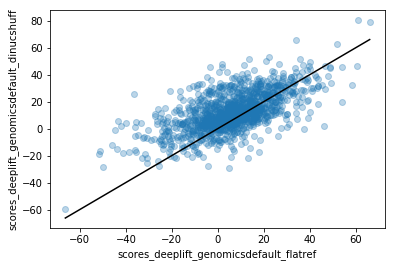

pos ranks sum 577416 neg ranks sum 192004
WilcoxonResult(statistic=192004.0, pvalue=1.0578685204083124e-52)


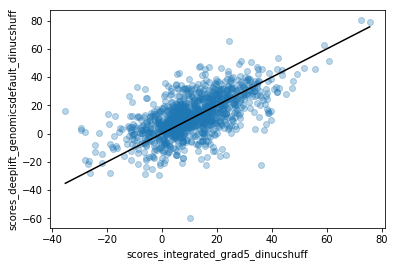

pos ranks sum 462772 neg ranks sum 306648
WilcoxonResult(statistic=306648.0, pvalue=6.04666984321388e-10)


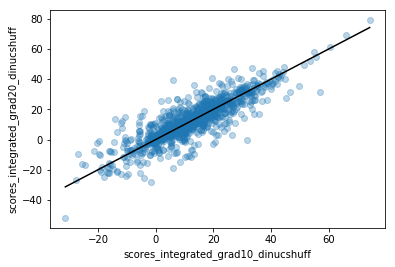

pos ranks sum 405481 neg ranks sum 363929
WilcoxonResult(statistic=361565.0, pvalue=0.099632633338014)


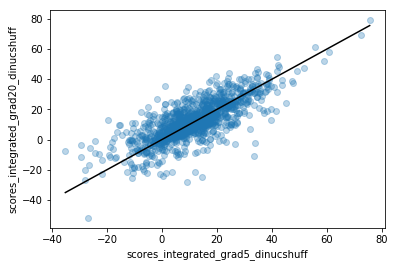

pos ranks sum 431378 neg ranks sum 338042
WilcoxonResult(statistic=338042.0, pvalue=0.00021550560561565664)


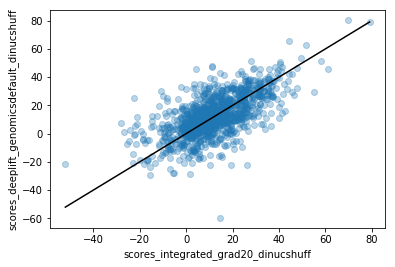

pos ranks sum 426807 neg ranks sum 342613
WilcoxonResult(statistic=342613.5, pvalue=0.0008448846348063323)


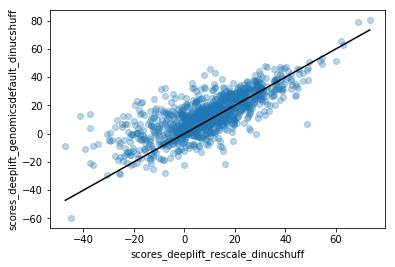

pos ranks sum 542246 neg ranks sum 227174
WilcoxonResult(statistic=227174.0, pvalue=8.426037984879952e-36)


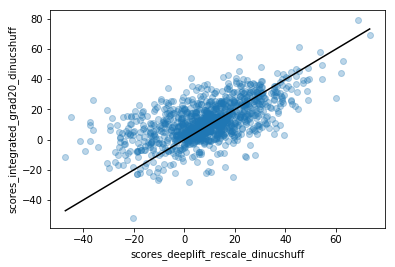

pos ranks sum 474730 neg ranks sum 294690
WilcoxonResult(statistic=294690.0, pvalue=9.517556679849511e-13)


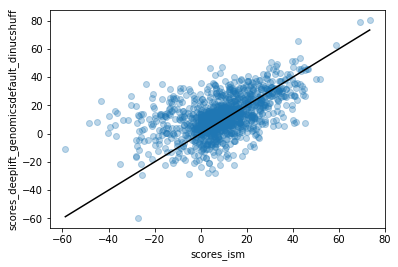

pos ranks sum 486573 neg ranks sum 282847
WilcoxonResult(statistic=282847.0, pvalue=6.676634895345879e-16)


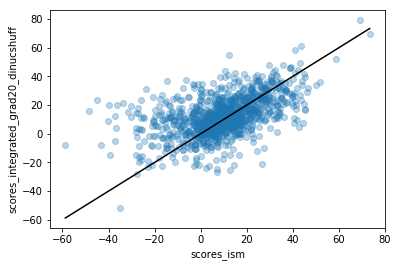

pos ranks sum 456085 neg ranks sum 313335
WilcoxonResult(statistic=313335.0, pvalue=1.5223521723278493e-08)


In [79]:
import scipy
from scipy import stats

def compare_methods(method_1_name, method_2_name, score_lookup):
    method_1_scores=score_lookup[method_1_name]
    method_2_scores=score_lookup[method_2_name]
    plt.scatter(method_1_scores, method_2_scores, alpha=0.3)
    plt.plot([np.min(method_1_scores), np.max(method_1_scores)],
             [np.min(method_1_scores), np.max(method_1_scores)],
             color="black")
    plt.xlabel(method_1_name)
    plt.ylabel(method_2_name)
    plt.show()
    differences = method_2_scores-method_1_scores
    sorted_differences = sorted(differences,key=lambda x:np.abs(x))
    #print(sorted_differences)
    positive_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] > 0])
    negative_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] < 0])
    print("pos ranks sum",positive_ranks, "neg ranks sum", negative_ranks)
    print(scipy.stats.wilcoxon(differences))
    
compare_methods(method_1_name="scores_deeplift_genomicsdefault_flatref",
                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                score_lookup=method_to_zerod_diffs)
compare_methods(method_1_name="scores_integrated_grad5_dinucshuff",
                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                score_lookup=method_to_zerod_diffs)
compare_methods(method_1_name="scores_integrated_grad10_dinucshuff",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=method_to_zerod_diffs)
compare_methods(method_1_name="scores_integrated_grad5_dinucshuff",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=method_to_zerod_diffs)
compare_methods(method_1_name="scores_integrated_grad20_dinucshuff",
                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                score_lookup=method_to_zerod_diffs)
compare_methods(method_1_name="scores_deeplift_rescale_dinucshuff",
                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                score_lookup=method_to_zerod_diffs)
compare_methods(method_1_name="scores_deeplift_rescale_dinucshuff",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=method_to_zerod_diffs)
compare_methods(method_1_name="scores_ism",
                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                score_lookup=method_to_zerod_diffs)
compare_methods(method_1_name="scores_ism",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=method_to_zerod_diffs)
#import seaborn as sns
#sns.violinplot(data=[method_to_zerod_diffs[x] for x in scoring_methods])


In [28]:
len(np.nonzero(scores > 2)[1])

714776